In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights
import numpy as np
import pandas as pd
#from sklearn import preprocessing, model_selection
from sklearn import model_selection
#from scipy.signal import butter,filtfilt,iirnotch,hilbert
from scipy.signal import butter,filtfilt
#from PyEMD import EMD
#import wandb
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
import scipy.io

In [4]:
# mat to tensor
wLen = 250 #ms
def getEMG (subject):
    sub = str(subject+1)
    mat_data = scipy.io.loadmat('./NinaproDB2/DB2_s' + sub + '/S' + sub + '_E1_A1.mat')
    mat_array = mat_data['emg']
    return torch.from_numpy(mat_array).unfold(dimension=0, size=wLen*2, step=100)

def getRestimulus (subject):
    sub = str(subject+1)
    mat_data = scipy.io.loadmat('./NinaproDB2/DB2_s' + sub + '/S' + sub + '_E1_A1.mat')
    mat_array = mat_data['restimulus']
    return torch.from_numpy(mat_array).unfold(dimension=0, size=wLen*2, step=100)

# removing excess rest windows
def balance (restimulus):
    numZero = 0
    indices = []
    #print(restimulus.shape)
    for x in range (len(restimulus)):
        L = torch.chunk(restimulus[x], 2, dim=1)
        if torch.equal(L[0], L[1]):
            if L[0][0][0] == 0:
                if (numZero < 550):
                    #print("working")
                    indices += [x]
                numZero += 1
            else:
                indices += [x]
    return indices

# making restimulus tensor match CNN output shape
def contract(R):
    labels = torch.tensor(())
    labels = labels.new_zeros(size=(len(R), 18))
    for x in range(len(R)):
        labels[x][int(R[x][0][0])] = 1.0
    return labels

b, a = butter(N=1, Wn=999.0, btype='lowpass', analog=False, fs=2000.0)
#b, a = butter(N=3, Wn=[20,450], btype='bandpass', analog=False, fs=2000.0)
#b, a = butter(N=3, Wn=5, btype='highpass', analog=False, fs=2000.0)
# sixth-order butterwortho filter only as powerline interferenced removed in dataset
def filter(emg):
    #return emg
    return torch.from_numpy(np.flip(filtfilt(b, a, emg),axis=0).copy())

cmap = mpl.colormaps['jet']

def getImages (emg):    
    allImages = []
    #for i in range(12):
        #s = preprocessing.StandardScaler().fit(np.abs(emg[:, i, :].numpy()))
        #emg[:, i, :] = torch.from_numpy(s.transform(np.abs(emg[:, i, :].numpy())))

    for i in range (len(emg)):
    #for i in range (100):
    #for i in range (105, 110):
        #s = preprocessing.StandardScaler().fit(np.abs(emg[i].numpy().T))
        #data = torch.from_numpy(s.transform(np.abs(emg[i].numpy().T)))
        #data = np.log(np.log(np.abs(emg[i].numpy())*10000.0+1))/3.0
        #data = np.log(np.log(np.abs(emg[i].numpy())*100000.0+1))
        #data = emg[i].numpy()*500.0
        data = np.log2(np.log2(((np.abs(emg[i].numpy()))*100000.0)+1))/2.75
        #data = np.abs(emg[i].numpy())*10000.0
        #data = np.log(((np.abs(emg[i].numpy()))*250000.0)+1)/5.0
        image = np.zeros((3, len(data), len(data[0])))
        
        #now = time.time()
        #image[:] = np.array(list(map(lambda col: np.fromiter(map(lambda x: (cmap(x))[:], col), dtype='float32'), data)))
        image = np.transpose(np.array(list(map(lambda col: np.array(list(map(lambda x: (cmap(x)), col))), data))), axes=[2, 0, 1])[:3]
        #image = np.array([(np.array([(cmap(x)) for x in col])) for col in data], dtype='float32')[:3]
        #image[0] = np.array(list(map(lambda col: np.fromiter(map(lambda x: (cmap(x))[0], col), dtype='float32'), data)))
        #image[1] = np.array(list(map(lambda col: np.fromiter(map(lambda x: (cmap(x))[1], col), dtype='float32'), data)))
        #image[2] = np.array(list(map(lambda col: np.fromiter(map(lambda x: (cmap(x))[2], col), dtype='float32'), data)))
        #print(time.time() - now)

        '''
        for p in range (len(data)):
            for q in range (len(data[p])):
                image[:, p, q] = cmap(data[p][q])[:3]
        '''
        image = transforms.Resize([72, 90], interpolation=transforms.InterpolationMode.BICUBIC, antialias=True)(torch.from_numpy(image))
        #image = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(torch.from_numpy(image))
        image = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image)
        allImages.append(image.numpy().astype(np.float32))

        if i % 1000 == 0:
            print("progress: " + str(i) + "/" + str(len(emg)))
            #print(labels[0][i])
        if (i % 5000 == 4999):
            plt.imshow(allImages[i].T, origin='lower')
            plt.axis('off')
            plt.show()
    return allImages


for i in range (0,40):
#i = 1
    file_path = "./NinaproDB2/rawImages_" + str(i+1) + ".npy"
    #data = getImages(all_emg[i])
    data = getImages(filter(getEMG(i)[balance(getRestimulus(i))]))
    np.save(file_path, data)
    file_path = "./NinaproDB2/label_" + str(i+1) + ".npy"
    #np.save(file_path, all_labels[i])
    np.save(file_path, contract(getRestimulus(i)[balance(getRestimulus(i))]))

i=0
#file_path = "./NinaproDB2/test.npy"
#data = getImages(filter(getEMG(i)[balance(getRestimulus(i))]))
#np.save(file_path, data)

#plt.imshow(data[0].T, origin='lower')
#plt.axis('off')
#plt.show()
'''
all_emg = []
all_labels = []
for i in range (10):
    #print(i)
    all_emg += [filter(getEMG(i)[balance(getRestimulus(i))])]
    all_labels += [contract(getRestimulus(i)[balance(getRestimulus(i))])]
'''

FileNotFoundError: [Errno 2] No such file or directory: './NinaproDB2/DB2_s1/S1_E1_A1.mat'

In [2]:
emg_1 = np.load("./NinaproDB2/rawImages_1.npy").astype(np.float16)
labels_1 = np.load("./NinaproDB2/label_1.npy").astype(np.float16)
emg_2 = np.load("./NinaproDB2/rawImages_2.npy").astype(np.float16)
labels_2 = np.load("./NinaproDB2/label_2.npy").astype(np.float16)
emg_3 = np.load("./NinaproDB2/rawImages_3.npy").astype(np.float16)
labels_3 = np.load("./NinaproDB2/label_3.npy").astype(np.float16)
emg_4 = np.load("./NinaproDB2/rawImages_4.npy").astype(np.float16)
labels_4 = np.load("./NinaproDB2/label_4.npy").astype(np.float16)
emg_5 = np.load("./NinaproDB2/rawImages_5.npy").astype(np.float16)
labels_5 = np.load("./NinaproDB2/label_5.npy").astype(np.float16)
emg_6 = np.load("./NinaproDB2/rawImages_6.npy").astype(np.float16)
labels_6 = np.load("./NinaproDB2/label_6.npy").astype(np.float16)
emg_7 = np.load("./NinaproDB2/rawImages_7.npy").astype(np.float16)
labels_7 = np.load("./NinaproDB2/label_7.npy").astype(np.float16)
emg_8 = np.load("./NinaproDB2/rawImages_8.npy").astype(np.float16)
labels_8 = np.load("./NinaproDB2/label_8.npy").astype(np.float16)
emg_9 = np.load("./NinaproDB2/rawImages_9.npy").astype(np.float16)
labels_9 = np.load("./NinaproDB2/label_9.npy").astype(np.float16)
emg_10 = np.load("./NinaproDB2/rawImages_10.npy").astype(np.float16)
labels_10 = np.load("./NinaproDB2/label_10.npy").astype(np.float16)
emg_11 = np.load("./NinaproDB2/rawImages_11.npy").astype(np.float16)
labels_11 = np.load("./NinaproDB2/label_11.npy").astype(np.float16)
emg_12 = np.load("./NinaproDB2/rawImages_12.npy").astype(np.float16)
labels_12 = np.load("./NinaproDB2/label_12.npy").astype(np.float16)
emg_13 = np.load("./NinaproDB2/rawImages_13.npy").astype(np.float16)
labels_13 = np.load("./NinaproDB2/label_13.npy").astype(np.float16)
emg_14 = np.load("./NinaproDB2/rawImages_14.npy").astype(np.float16)
labels_14 = np.load("./NinaproDB2/label_14.npy").astype(np.float16)
emg_15 = np.load("./NinaproDB2/rawImages_15.npy").astype(np.float16)
labels_15 = np.load("./NinaproDB2/label_15.npy").astype(np.float16)
emg_16 = np.load("./NinaproDB2/rawImages_16.npy").astype(np.float16)
labels_16 = np.load("./NinaproDB2/label_16.npy").astype(np.float16)
emg_17 = np.load("./NinaproDB2/rawImages_17.npy").astype(np.float16)
labels_17 = np.load("./NinaproDB2/label_17.npy").astype(np.float16)
emg_18 = np.load("./NinaproDB2/rawImages_18.npy").astype(np.float16)
labels_18 = np.load("./NinaproDB2/label_18.npy").astype(np.float16)
emg_19 = np.load("./NinaproDB2/rawImages_19.npy").astype(np.float16)
labels_19 = np.load("./NinaproDB2/label_19.npy").astype(np.float16)
emg_20 = np.load("./NinaproDB2/rawImages_20.npy").astype(np.float16)
labels_20 = np.load("./NinaproDB2/label_20.npy").astype(np.float16)
emg_21 = np.load("./NinaproDB2/rawImages_21.npy").astype(np.float16)
labels_21 = np.load("./NinaproDB2/label_21.npy").astype(np.float16)
emg_22 = np.load("./NinaproDB2/rawImages_22.npy").astype(np.float16)
labels_22 = np.load("./NinaproDB2/label_22.npy").astype(np.float16)
emg_23 = np.load("./NinaproDB2/rawImages_23.npy").astype(np.float16)
labels_23 = np.load("./NinaproDB2/label_23.npy").astype(np.float16)
emg_24 = np.load("./NinaproDB2/rawImages_24.npy").astype(np.float16)
labels_24 = np.load("./NinaproDB2/label_24.npy").astype(np.float16)
emg_25 = np.load("./NinaproDB2/rawImages_25.npy").astype(np.float16)
labels_25 = np.load("./NinaproDB2/label_25.npy").astype(np.float16)
emg_26 = np.load("./NinaproDB2/rawImages_26.npy").astype(np.float16)
labels_26 = np.load("./NinaproDB2/label_26.npy").astype(np.float16)
emg_27 = np.load("./NinaproDB2/rawImages_27.npy").astype(np.float16)
labels_27 = np.load("./NinaproDB2/label_27.npy").astype(np.float16)
emg_28 = np.load("./NinaproDB2/rawImages_28.npy").astype(np.float16)
labels_28 = np.load("./NinaproDB2/label_28.npy").astype(np.float16)
emg_29 = np.load("./NinaproDB2/rawImages_29.npy").astype(np.float16)
labels_29 = np.load("./NinaproDB2/label_29.npy").astype(np.float16)
emg_30 = np.load("./NinaproDB2/rawImages_30.npy").astype(np.float16)
labels_30 = np.load("./NinaproDB2/label_30.npy").astype(np.float16)
emg_31 = np.load("./NinaproDB2/rawImages_31.npy").astype(np.float16)
labels_31 = np.load("./NinaproDB2/label_31.npy").astype(np.float16)
emg_32 = np.load("./NinaproDB2/rawImages_32.npy").astype(np.float16)
labels_32 = np.load("./NinaproDB2/label_32.npy").astype(np.float16)
emg_33 = np.load("./NinaproDB2/rawImages_33.npy").astype(np.float16)
labels_33 = np.load("./NinaproDB2/label_33.npy").astype(np.float16)
emg_34 = np.load("./NinaproDB2/rawImages_34.npy").astype(np.float16)
labels_34 = np.load("./NinaproDB2/label_34.npy").astype(np.float16)
emg_35 = np.load("./NinaproDB2/rawImages_35.npy").astype(np.float16)
labels_35 = np.load("./NinaproDB2/label_35.npy").astype(np.float16)
emg_36 = np.load("./NinaproDB2/rawImages_36.npy").astype(np.float16)
labels_36 = np.load("./NinaproDB2/label_36.npy").astype(np.float16)
emg_37 = np.load("./NinaproDB2/rawImages_37.npy").astype(np.float16)
labels_37 = np.load("./NinaproDB2/label_37.npy").astype(np.float16)
emg_38 = np.load("./NinaproDB2/rawImages_38.npy").astype(np.float16)
labels_38 = np.load("./NinaproDB2/label_38.npy").astype(np.float16)
emg_39 = np.load("./NinaproDB2/rawImages_39.npy").astype(np.float16)
labels_39 = np.load("./NinaproDB2/label_39.npy").astype(np.float16)
emg_40 = np.load("./NinaproDB2/rawImages_40.npy").astype(np.float16)
labels_40 = np.load("./NinaproDB2/label_40.npy").astype(np.float16)

leaveOut = False
data = np.concatenate((emg_1, emg_2, emg_3, emg_4, emg_5, emg_6, emg_7, emg_8, emg_9, emg_10,
                       emg_11, emg_12, emg_13, emg_14, emg_15, emg_16, emg_17, emg_18, emg_19, emg_20,
                       emg_21, emg_22, emg_23, emg_24, emg_25, emg_26, emg_27, emg_28, emg_29, emg_30,
                       emg_31, emg_32, emg_33, emg_34, emg_35, emg_36, emg_37, emg_38, emg_39, emg_40), axis=0, dtype=np.float16)
combined_labels = np.concatenate((labels_1, labels_2, labels_3, labels_4, labels_5, labels_6, labels_7, labels_8, labels_9, labels_10,
                                  labels_11, labels_12, labels_13, labels_14, labels_15, labels_16, labels_17, labels_18, labels_19, labels_20,
                                  labels_21, labels_22, labels_23, labels_24, labels_25, labels_26, labels_27, labels_28, labels_29, labels_30,
                                  labels_31, labels_32, labels_33, labels_34, labels_35, labels_36, labels_37, labels_38, labels_39, labels_40), axis=0, dtype=np.float16)

#data = np.concatenate((emg_1, emg_2), axis=0, dtype=np.float16)
#combined_labels = np.concatenate((labels_1, labels_2), axis=0, dtype=np.float16)
#data = np.load("./NinaproDB2/test.npy").astype(np.float16)
#combined_labels = np.load("./NinaproDB2/label_1.npy").astype(np.float16)

X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(data, combined_labels, test_size=0.2)
if leaveOut:
    X_test = outEMG
    Y_test = outLabels
else:
    X_validation, X_test, Y_validation, Y_test = model_selection.train_test_split(X_validation, Y_validation, test_size=0.5)

X_train = torch.from_numpy(X_train).to(torch.float32)
Y_train = torch.from_numpy(Y_train).to(torch.float32)
X_validation = torch.from_numpy(X_validation).to(torch.float32)
Y_validation = torch.from_numpy(Y_validation).to(torch.float32)
X_test = torch.from_numpy(X_test).to(torch.float32)
Y_test = torch.from_numpy(Y_test).to(torch.float32)
print(X_train.size())
print(X_validation.size())
print(X_test.size())

: 

: 

In [2]:
labels_1 = np.load("./NinaproDB2/label_1.npy").astype(np.float16)
labels_2 = np.load("./NinaproDB2/label_2.npy").astype(np.float16)
labels_3 = np.load("./NinaproDB2/label_3.npy").astype(np.float16)
labels_4 = np.load("./NinaproDB2/label_4.npy").astype(np.float16)
labels_5 = np.load("./NinaproDB2/label_5.npy").astype(np.float16)
labels_6 = np.load("./NinaproDB2/label_6.npy").astype(np.float16)
labels_7 = np.load("./NinaproDB2/label_7.npy").astype(np.float16)
labels_8 = np.load("./NinaproDB2/label_8.npy").astype(np.float16)
labels_9 = np.load("./NinaproDB2/label_9.npy").astype(np.float16)
labels_10 = np.load("./NinaproDB2/label_10.npy").astype(np.float16)
combined_labels = np.concatenate((labels_1, labels_2, labels_3, labels_4, labels_5, labels_6, labels_7, labels_8, labels_9, labels_10), axis=0, dtype=np.float16)
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(np.concatenate((np.load("./NinaproDB2/rawImages_1.npy").astype(np.float16),
                                                                                                np.load("./NinaproDB2/rawImages_2.npy").astype(np.float16),
                                                                                                np.load("./NinaproDB2/rawImages_3.npy").astype(np.float16),
                                                                                                np.load("./NinaproDB2/rawImages_4.npy").astype(np.float16),
                                                                                                np.load("./NinaproDB2/rawImages_5.npy").astype(np.float16),
                                                                                                np.load("./NinaproDB2/rawImages_6.npy").astype(np.float16),
                                                                                                np.load("./NinaproDB2/rawImages_7.npy").astype(np.float16),
                                                                                                np.load("./NinaproDB2/rawImages_8.npy").astype(np.float16),
                                                                                                np.load("./NinaproDB2/rawImages_9.npy").astype(np.float16),
                                                                                                np.load("./NinaproDB2/rawImages_10.npy").astype(np.float16)), axis=0, dtype=np.float16), combined_labels, test_size=0.2)
X_validation, X_test, Y_validation, Y_test = model_selection.train_test_split(X_validation, Y_validation, test_size=0.5)

X_train = torch.from_numpy(X_train).to(torch.float32)
Y_train = torch.from_numpy(Y_train).to(torch.float32)
X_validation = torch.from_numpy(X_validation).to(torch.float32)
Y_validation = torch.from_numpy(Y_validation).to(torch.float32)
X_test = torch.from_numpy(X_test).to(torch.float32)
Y_test = torch.from_numpy(Y_test).to(torch.float32)
print(X_train.size())
print(X_validation.size())
print(X_test.size())

torch.Size([69988, 3, 72, 100])
torch.Size([8749, 3, 72, 100])
torch.Size([8749, 3, 72, 100])


In [4]:
labels_1 = np.load("./NinaproDB2/label_1.npy").astype(np.float16)
labels_2 = np.load("./NinaproDB2/label_2.npy").astype(np.float16)
combined_labels = np.concatenate((labels_1, labels_2), axis=0, dtype=np.float16)
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(np.concatenate((np.load("./NinaproDB2/rawImages_1.npy").astype(np.float16),
                                                                                                np.load("./NinaproDB2/rawImages_2.npy").astype(np.float16)),
                                                                                                 axis=0, dtype=np.float16), combined_labels, test_size=0.2)
X_validation, X_test, Y_validation, Y_test = model_selection.train_test_split(X_validation, Y_validation, test_size=0.5)

X_train = torch.from_numpy(X_train).to(torch.float32)
Y_train = torch.from_numpy(Y_train).to(torch.float32)
X_validation = torch.from_numpy(X_validation).to(torch.float32)
Y_validation = torch.from_numpy(Y_validation).to(torch.float32)
X_test = torch.from_numpy(X_test).to(torch.float32)
Y_test = torch.from_numpy(Y_test).to(torch.float32)
print(X_train.size())
print(X_validation.size())
print(X_test.size())

torch.Size([13112, 3, 72, 90])
torch.Size([1639, 3, 72, 90])
torch.Size([1640, 3, 72, 90])


In [5]:
model = resnet50(weights=ResNet50_Weights.DEFAULT)
model = nn.Sequential(*list(model.children())[:-2])
#model = nn.Sequential(*list(model.children())[:-4])
num_features = model[-1][-1].conv3.out_channels
#num_features = model.fc.in_features
dropout = 0.5
model.add_module('avgpool', nn.AdaptiveAvgPool2d(1))
model.add_module('flatten', nn.Flatten())
model.add_module('fc1', nn.Linear(num_features, 512))
model.add_module('relu', nn.ReLU())
model.add_module('dropout1', nn.Dropout(dropout))
model.add_module('fc2', nn.Linear(512, 512))
model.add_module('relu2', nn.ReLU())
model.add_module('dropout2', nn.Dropout(dropout))
model.add_module('fc3', nn.Linear(512, 18))
model.add_module('softmax', nn.Softmax(dim=1))

num = 0
for name, param in model.named_parameters():
    num += 1
    #if (num > 72):
    #if (num > 33): #for -4
    if (num >= 0):
        param.requires_grad = True
    else:
        param.requires_grad = False

#layers = [(name, param.requires_grad) for name, param in model.named_parameters()]
#for i in range(len(layers)):
    #print(layers[i])

In [6]:
class Data(Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)

batch_size = 64
train_loader = DataLoader(list(zip(X_train, Y_train)), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(list(zip(X_validation, Y_validation)), batch_size=batch_size)
test_loader = DataLoader(list(zip(X_test, Y_test)), batch_size=batch_size)

In [7]:
# loss function and optimizer
criterion = nn.CrossEntropyLoss()
learn = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learn)

cuda
Epoch 1/25 | Train Loss: 2.0502 | Val Loss: 2.1310
Train Accuracy: 0.9329 | Val Accuracy: 0.8523
Epoch 2/25 | Train Loss: 2.0477 | Val Loss: 2.1473
Train Accuracy: 0.9353 | Val Accuracy: 0.8357
Epoch 3/25 | Train Loss: 2.0446 | Val Loss: 2.1548
Train Accuracy: 0.9383 | Val Accuracy: 0.8294
Epoch 4/25 | Train Loss: 2.0426 | Val Loss: 2.1356
Train Accuracy: 0.9395 | Val Accuracy: 0.8488
Epoch 5/25 | Train Loss: 2.0316 | Val Loss: 2.1379
Train Accuracy: 0.9510 | Val Accuracy: 0.8435
Epoch 6/25 | Train Loss: 2.0300 | Val Loss: 2.1458
Train Accuracy: 0.9526 | Val Accuracy: 0.8362
Epoch 7/25 | Train Loss: 2.0275 | Val Loss: 2.1225
Train Accuracy: 0.9552 | Val Accuracy: 0.8607
Epoch 8/25 | Train Loss: 2.0256 | Val Loss: 2.1143
Train Accuracy: 0.9568 | Val Accuracy: 0.8668
Epoch 9/25 | Train Loss: 2.0269 | Val Loss: 2.0928
Train Accuracy: 0.9553 | Val Accuracy: 0.8901
Epoch 10/25 | Train Loss: 2.0173 | Val Loss: 2.0922
Train Accuracy: 0.9648 | Val Accuracy: 0.8909
Epoch 11/25 | Train Loss

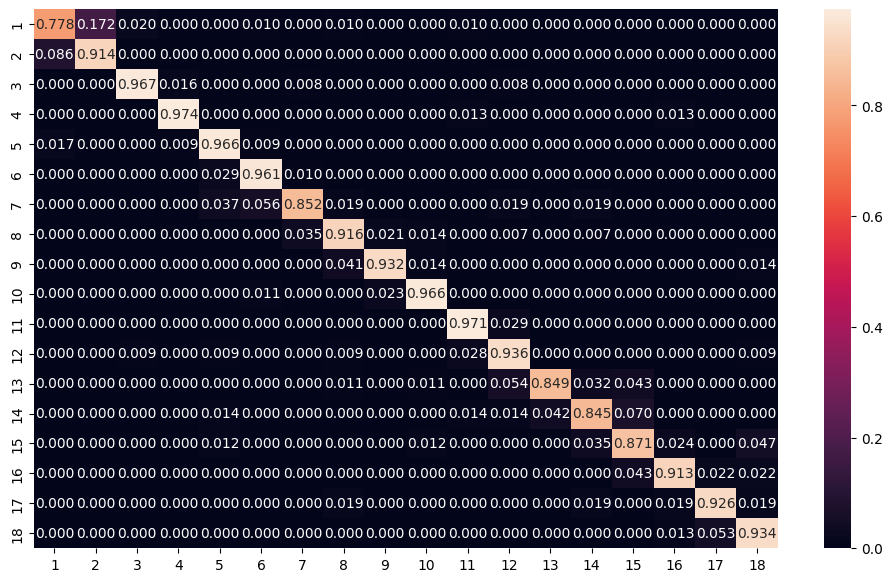

In [9]:
# Training loop
import gc
gc.collect()
torch.cuda.empty_cache()

#run = wandb.init(name='CNN', project='emg_benchmarking', entity='msoh')
#wandb.config.lr = learn

num_epochs = 25
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

#wandb.watch(model)

for epoch in range(num_epochs):
    model.train()
    train_acc = 0.0
    train_loss = 0.0
    for X_batch, Y_batch in train_loader:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, Y_batch)
        train_loss += loss.item()

        train_acc += np.mean(np.argmax(output.cpu().detach().numpy(), 
                                       axis=1) == np.argmax(Y_batch.cpu().detach().numpy(), axis=1))

        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    with torch.no_grad():
        for X_batch, Y_batch in val_loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            output = model(X_batch)
            val_loss += criterion(output, Y_batch).item()

            val_acc += np.mean(np.argmax(output.cpu().detach().numpy(), axis=1) == np.argmax(Y_batch.cpu().detach().numpy(), axis=1))

    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    val_loss /= len(val_loader)
    val_acc /= len(val_loader)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Train Accuracy: {train_acc:.4f} | Val Accuracy: {val_acc:.4f}")

    '''
    wandb.log({
        "Epoch": epoch,
        "Train Loss": train_loss,
        "Train Acc": train_acc,
        "Valid Loss": val_loss,
        "Valid Acc": val_acc})
    '''
#run.finish()

# Testing
pred = []
true = []

model.eval()
test_loss = 0.0
test_acc = 0.0
with torch.no_grad():
    for X_batch, Y_batch in test_loader:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        output = model(X_batch)
        test_loss += criterion(output, Y_batch).item()

        test_acc += np.mean(np.argmax(output.cpu().detach().numpy(), axis=1) == np.argmax(Y_batch.cpu().detach().numpy(), axis=1))

        output = np.argmax(output.cpu().detach().numpy(), axis=1)
        pred.extend(output)
        labels = np.argmax(Y_batch.cpu().detach().numpy(), axis=1)
        true.extend(labels)

test_loss /= len(test_loader)
test_acc /= len(test_loader)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

cf_matrix = confusion_matrix(true, pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = np.arange(1, 19, 1),
                     columns = np.arange(1, 19, 1))
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True, fmt=".3f")
plt.savefig('output.png')